##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train Your Own Model and Convert It to TFLite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c03_exercise_convert_model_to_tflite.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c03_exercise_convert_model_to_tflite.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing we'll use here.

This uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

# Setup

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pathlib

print(tf.__version__)

2.4.1


# Download Fashion MNIST Dataset


In [5]:
#splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

dataset, info = tfds.load(
    'fashion_mnist', 
    with_info=True, 
    as_supervised=True, 
    split=['train[80%:]', 'train[80%:90%]', 'train[90%:]'],
    )

(train_examples, validation_examples, test_examples) = splits

train_dataset, validation_dataset, test_dataset = dataset[0], dataset[1], dataset[2]

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [8]:
num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples

print("Number of train examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of train examples: 60000
Number of test examples:     10000


In [9]:
num_training_examples = 0
num_validation_examples = 0
num_testing_examples = 0

for example in train_examples:
  num_training_examples += 1

for example in validation_examples:
  num_validation_examples += 1

for example in test_examples:
  num_testing_examples += 1

print(num_examples)
print(num_training_examples)
print(num_testing_examples)
print(num_validation_examples)

60000
12000
6000
6000


In [10]:
num2_training_examples = 0
num2_validation_examples = 0
num2_testing_examples = 0

for example in train_dataset:
  num2_training_examples += 1

for example in validation_dataset:
  num2_validation_examples += 1

for example in test_dataset:
  num2_testing_examples += 1

print(num_examples)
print(num2_training_examples)
print(num2_testing_examples)
print(num2_validation_examples)

60000
12000
6000
6000


In [11]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [12]:
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Images: {}'.format(num_examples))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Testing Images: {}'.format(num_testing_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 10
Total Number of Images: 60000
Total Number of Training Images: 12000
Total Number of Testing Images: 6000
Total Number of Validation Images: 6000 



In [13]:
with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

In [14]:
IMG_SIZE = 28

# Preprocessing data

## Preprocess

In [22]:
# Write a function to normalize and resize the images

def format_example(image, label):
  # Cast image to float32
  image = tf.cast(image, tf.float32) # YOUR CODE HERE
  # Resize the image if necessary
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) # YOUR CODE HERE
  # Normalize the image in the range [0, 1]
  image = image / 255.0 # YOUR CODE HERE
  return image, label

In [16]:
# Set the batch size to 32

BATCH_SIZE = 32

## Create a Dataset from images and labels

In [24]:
# Prepare the examples by preprocessing the them and then batching them (and optionally prefetching them)

# If you wish you can shuffle train set here
train_batches = train_examples.shuffle(num_training_examples).map(format_example).batch(BATCH_SIZE).prefetch(1) # YOUR CODE HERE

validation_batches = validation_examples.cache().batch(BATCH_SIZE).map(format_example).prefetch(1) # YOUR CODE HERE
test_batches = test_examples.cache().batch(1).map(format_example) # YOUR CODE HERE

# Building the model

In [ ]:
"""
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
=================================================================
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
"""

In [28]:
# Build the model shown in the previous cell

model = tf.keras.Sequential([
  # Set the input shape to (28, 28, 1), kernel size=3, filters=16 and use ReLU activation,  
  tf.keras.layers.Conv2D(16, (3,3), padding='same', activation=tf.nn.relu,
                         input_shape=(IMG_SIZE, IMG_SIZE, 1)), # YOUR CODE HERE    
  tf.keras.layers.MaxPooling2D((2, 2), strides=2),
  # Set the number of filters to 32, kernel size to 3 and use ReLU activation 
  tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu), # YOUR CODE HERE
  # Flatten the output layer to 1 dimension
  tf.keras.layers.Flatten(),
  # Add a fully connected layer with 64 hidden units and ReLU activation
  tf.keras.layers.Dense(64, activation=tf.nn.relu), # YOUR CODE HERE
  # Attach a final softmax classification head
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)]) # YOUR CODE HERE

# Set the loss and accuracy metrics
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),# YOUR CODE HERE 
    metrics=['accuracy'])# YOUR CODE HERE
      

## Train

In [29]:
model.fit(train_batches, 
          epochs=10,
          validation_data=validation_batches)

Epoch 1/10
375/375 [==============================] - 34s 5ms/step - loss: 0.8645 - accuracy: 0.7062 - val_loss: 0.3874 - val_accuracy: 0.8668
Epoch 2/10
375/375 [==============================] - 2s 4ms/step - loss: 0.3821 - accuracy: 0.8647 - val_loss: 0.3055 - val_accuracy: 0.8888
Epoch 3/10
375/375 [==============================] - 2s 4ms/step - loss: 0.3221 - accuracy: 0.8839 - val_loss: 0.2664 - val_accuracy: 0.8993
Epoch 4/10
375/375 [==============================] - 2s 4ms/step - loss: 0.2657 - accuracy: 0.9020 - val_loss: 0.2287 - val_accuracy: 0.9217
Epoch 5/10
375/375 [==============================] - 2s 4ms/step - loss: 0.2316 - accuracy: 0.9129 - val_loss: 0.2489 - val_accuracy: 0.9062
Epoch 6/10
375/375 [==============================] - 2s 4ms/step - loss: 0.1950 - accuracy: 0.9303 - val_loss: 0.1596 - val_accuracy: 0.9438
Epoch 7/10
375/375 [==============================] - 2s 4ms/step - loss: 0.1630 - accuracy: 0.9397 - val_loss: 0.1394 - val_accuracy: 0.9528
Epoch

# Exporting to TFLite

In [30]:
export_dir = 'saved_model/1'

# Use the tf.saved_model API to export the SavedModel

# Your Code Here
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


In [31]:
#@title Select mode of optimization
mode = "Default" #@param ["Default", "Storage", "Speed"]

if mode == 'Storage':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
  optimization = tf.lite.Optimize.DEFAULT

In [32]:
optimization

<Optimize.DEFAULT: 'DEFAULT'>

In [33]:
# Use the TFLiteConverter SavedModel API to initialize the converter
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir) # YOUR CODE HERE

# Set the optimzations
converter.optimizations = [optimization] # YOUR CODE HERE

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert() # YOUR CODE HERE

In [34]:
tflite_model_file = 'model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

# Test if your model is working

In [35]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [36]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  test_labels.append(label[0])
  test_images.append(np.array(img))

In [39]:
#@title Utility functions for plotting
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label.numpy():
    color = 'green'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks(list(range(10)), class_names, rotation='vertical')
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array[0])

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('green')

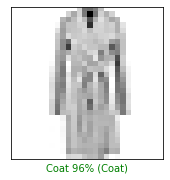

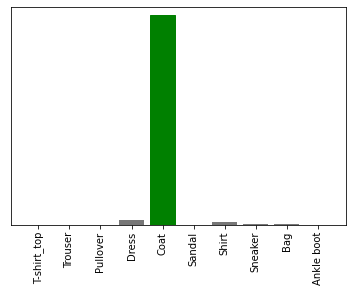

In [45]:
#@title Visualize the outputs { run: "auto" }
index = 40 #@param {type:"slider", min:1, max:50, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.show()
plot_value_array(index, predictions, test_labels)
plt.show()

# Download TFLite model and assets

**NOTE: You might have to run to the cell below twice**

In [ ]:
try:
  from google.colab import files
  files.download(tflite_model_file)
  files.download('labels.txt')
except:
  pass

# Deploying TFLite model

Now once you've the trained TFLite model downloaded, you can ahead and deploy this on an Android/iOS application by placing the model assets in the appropriate location.

# Prepare the test images for download (Optional)

In [ ]:
!mkdir -p test_images

In [ ]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
  image = tf.cast(image * 255.0, tf.uint8)
  image = tf.squeeze(image).numpy()
  pil_image = Image.fromarray(image)
  pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]].lower(), index))

In [ ]:
!ls test_images

In [ ]:
!zip -qq fmnist_test_images.zip -r test_images/

In [ ]:
try:
  files.download('fmnist_test_images.zip')
except:
  pass